<div style="background-color: #FFEB3B; padding: 20px; border-radius: 10px; box-shadow: 2px 2px 10px #888888;">
  <h1 style="text-align: center; font-family: Arial, sans-serif; color: #333333;">🌾 Rice Crop Diseases Classification using VGG16 🌿</h1>
</div>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2024-07-06 22:47:16.687339: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 22:47:16.687468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 22:47:16.860125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Directory containing the dataset
base_dir = '/kaggle/input/rice-crop-diseases/Rice_Diseases'
categories = ['Bacterial Blight Disease', 'Blast Disease', 'Brown Spot Disease', 'False Smut Disease']

In [3]:
# Load dataset
def load_images(base_dir, categories, img_size=(128, 128)):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(base_dir, category)
        for filename in os.listdir(category_path):
            if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
                img_path = os.path.join(category_path, filename)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(category)
    return np.array(images), np.array(labels)

images, labels = load_images(base_dir, categories)

In [4]:
# Display sample images
def display_sample_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        idx = np.random.randint(len(images))
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names[labels[idx]])
        plt.axis('off')
    plt.show()

In [5]:
# Data Preprocessing
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded)

In [6]:

# Normalize images
images = images / 255.0

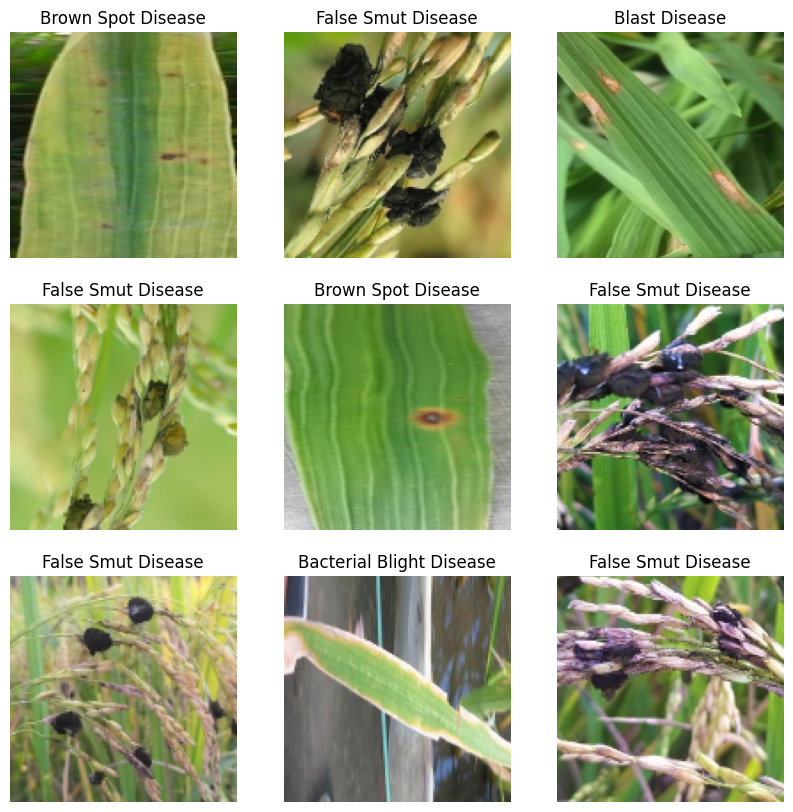

In [7]:
class_names = le.classes_
display_sample_images(images, labels_encoded.argmax(axis=1), class_names)

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

In [9]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [10]:
# Load pre-trained VGG16 model and add custom layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model = Sequential()
model.add(vgg_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Freeze the VGG16 base layers
vgg_base.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Model Training with callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.3404 - loss: 2.9061 - val_accuracy: 0.6176 - val_loss: 1.9836 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5384 - loss: 1.5217 - val_accuracy: 0.7941 - val_loss: 0.8097 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.7907 - loss: 0.9215 - val_accuracy: 0.6471 - val_loss: 0.9020 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.7715 - loss: 0.7621 - val_accuracy: 0.8529 - val_loss: 0.3389 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.7827 - loss: 0.6559 - val_accuracy: 0.8529 - val_loss: 0.3433 - learning_rate: 0.0010
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.8727 - loss: 0.2926 - val_accuracy: 0.8235 - val_loss: 0.7080 - learning_rate: 0.0010
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8369 - loss: 0.4299 - val_accuracy: 0.8529 - val_loss: 0.2797

In [13]:
# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9400 - loss: 0.1395
Test Accuracy: 94.12%


In [14]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 352ms/step


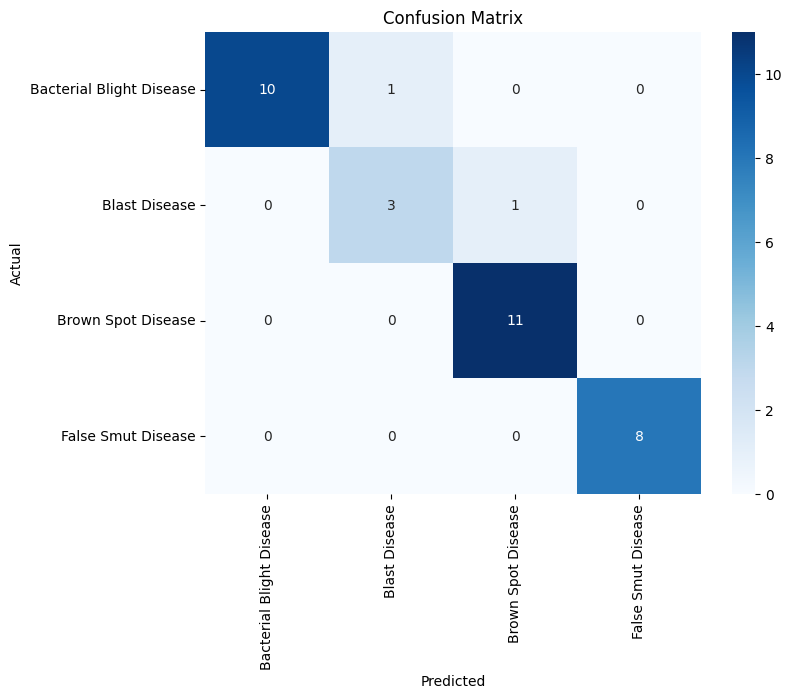

In [15]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Classification Report
class_report = classification_report(y_true, y_pred_classes, target_names=class_names)
print('Classification Report:')
print(class_report)


Classification Report:
                          precision    recall  f1-score   support

Bacterial Blight Disease       1.00      0.91      0.95        11
           Blast Disease       0.75      0.75      0.75         4
      Brown Spot Disease       0.92      1.00      0.96        11
      False Smut Disease       1.00      1.00      1.00         8

                accuracy                           0.94        34
               macro avg       0.92      0.91      0.91        34
            weighted avg       0.94      0.94      0.94        34



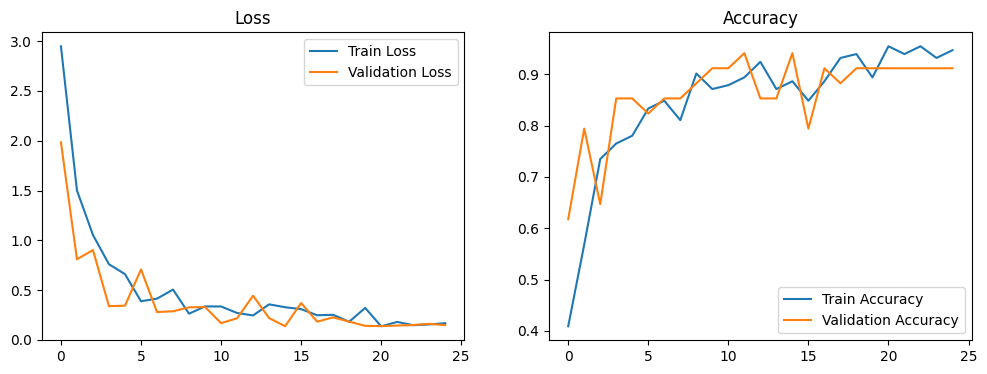

In [17]:

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

<div style="background-color: #FFEB3B; padding: 20px; border-radius: 10px; box-shadow: 2px 2px 10px #888888;">
  <h1 style="text-align: center; font-family: Arial, sans-serif; color: #333333;">👍 If you like my notebook, please upvote! 👍</h1>
</div>